In [ ]:
# default_exp diagnoser

# Diagnoser

> Diagnostic metrics for datasets.

In [ ]:
#hide
from nbdev.showdoc import *

# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# export
import torch
from multiprocessing import Pool
import numpy as np
from scipy.spatial.distance import cosine as cos_distance
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

def mapper(n_jobs):
    '''
    Function for parallel computing: 
    Original Implementation: https://github.com/molecularsets/moses/blob/master/moses/utils.py
    
    Returns function for map call.
    If n_jobs == 1, will use standard map
    If n_jobs > 1, will use multiprocessing pool
    If n_jobs is a pool object, will return its map function
    '''
    if n_jobs == 1:
        def _mapper(*args, **kwargs):
            return list(map(*args, **kwargs))

        return _mapper
    elif isinstance(n_jobs, int):
        pool = Pool(n_jobs)

        def _mapper(*args, **kwargs):
            try:
                result = pool.map(*args, **kwargs)
            finally:
                pool.terminate()
            return result

        return _mapper
    else:
        return n_jobs.map
    
def cos_similarity(train_counts, test_counts):
    """
    Computes cosine similarity between two (e.g., train and test)
     dictionaries of form {smiles: count}. Non-present
     elements are considered zero:
     sim = <r, g> / ||r|| / ||g||
    """
    if len(train_counts) == 0 or len(test_counts) == 0:
        return np.nan
    keys = np.unique(list(train_counts.keys()) + list(test_counts.keys()))
    train_vec = np.array([train_counts.get(k, 0) for k in keys])
    test_vec = np.array([test_counts.get(k, 0) for k in keys])
    return 1 - cos_distance(train_vec, test_vec)

def fingerprints_generator(smi):
    mol = Chem.MolFromSmiles(smi)
    fingerprint = np.asarray(GetMorganFingerprintAsBitVect(mol,3, nBits=1024))
    return fingerprint

def collect_fingerprints(smi_list, n_jobs=1):
    '''
    Generates Morgan fingerprint (radius=3, bit= 1024) for a list of SMILES.
    
    '''
    morgan_fps = mapper(n_jobs)(
        partial(fingerprints_generator), smi_list
    )
    morgan_fps = np.vstack(morgan_fps)
    return morgan_fps

def average_agg_tanimoto(stock_vecs, gen_vecs,
                         batch_size=5000, agg='max',
                         device='cpu', p=1):
    """
    For each molecule in gen_vecs finds closest molecule in stock_vecs.
    Returns average tanimoto score for between these molecules
    Parameters:
        stock_vecs: numpy array <n_vectors x dim>
        gen_vecs: numpy array <n_vectors' x dim>
        agg: max or mean
        p: power for averaging: (mean x^p)^(1/p)
    """
    assert agg in ['max', 'mean'], "Can aggregate only max or mean"
    agg_tanimoto = np.zeros(len(gen_vecs))
    total = np.zeros(len(gen_vecs))
    for j in range(0, stock_vecs.shape[0], batch_size):
        x_stock = torch.tensor(stock_vecs[j:j + batch_size]).to(device).float()
        for i in range(0, gen_vecs.shape[0], batch_size):
            y_gen = torch.tensor(gen_vecs[i:i + batch_size]).to(device).float()
            y_gen = y_gen.transpose(0, 1)
            tp = torch.mm(x_stock, y_gen)
            jac = (tp / (x_stock.sum(1, keepdim=True) +
                         y_gen.sum(0, keepdim=True) - tp)).cpu().numpy()
            jac[np.isnan(jac)] = 1
            if p != 1:
                jac = jac**p
            if agg == 'max':
                agg_tanimoto[i:i + y_gen.shape[1]] = np.maximum(
                    agg_tanimoto[i:i + y_gen.shape[1]], jac.max(0))
            elif agg == 'mean':
                agg_tanimoto[i:i + y_gen.shape[1]] += jac.sum(0)
                total[i:i + y_gen.shape[1]] += jac.shape[0]
    if agg == 'mean':
        agg_tanimoto /= total
    if p != 1:
        agg_tanimoto = (agg_tanimoto)**(1/p)
    return np.mean(agg_tanimoto)

## Fragment Similarity

In [ ]:
# export

from collections import Counter
from rdkit.Chem import AllChem
from rdkit import Chem

def fragments_generator(smi):
    """
    fragment mol using BRICS and return smiles list
    """
    fgs = AllChem.FragmentOnBRICSBonds(Chem.MolFromSmiles(smi))
    fgs_smi = Chem.MolToSmiles(fgs).split(".")
    return fgs_smi

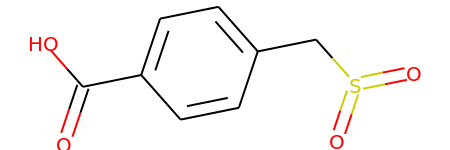

In [ ]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

smi = 'O=C(O)c1ccc(C[S](=O)=O)cc1'
mol = Chem.MolFromSmiles(smi)
mol

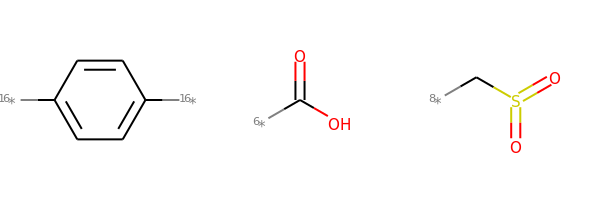

In [ ]:
frgs = fragments_generator(smi)
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in frgs])

In [ ]:
# export
def collect_fragments(smi_list, n_jobs=1):
    """
    fragment a list of smiles using BRICS and return a dictionary of form {'fragment smiles': count}
    """
    fragments = Counter()
    for mol_frag in mapper(n_jobs)(fragments_generator, smi_list):
        fragments.update(mol_frag)
    return fragments

In [ ]:
smiles_list = ['O=C(O)c1ccc(C[S](=O)=O)cc1',
         'O=C(O)c1ccccc1',
          'N[C@H](CCC=O)C(=O)O',
          'N[C@@H](CCC=O)C(=O)O'
         ]

collect_fragments(smiles_list)

Counter({'[16*]c1ccc([16*])cc1': 1,
         '[6*]C(=O)O': 2,
         '[8*]C[S](=O)=O': 1,
         '[16*]c1ccccc1': 1,
         'N[C@H](CCC=O)C(=O)O': 1,
         'N[C@@H](CCC=O)C(=O)O': 1})

In [ ]:
smi_list2 = ['O=C(O)c1ccc(C[S](=O)=O)cc1',
         'O=C(O)c1ccccc1',
          'N[C@H](CCC=O)C(=O)O',
          'N[C@@H](CCC=O)C(=O)O',
          'O=c1cccc[nH]1',
          'Oc1ccccn1', 'CSc1c(C(=O)NC2C3CC4CC(C3)CC2C4)cnn1-c1ccc(C(=O)O)cc1']

## Functional Groups Similarity

In [ ]:
# export

from rdkit.Chem import rdmolops

def merge(mol, marked, aset):
    bset = set()
    for idx in aset:
        atom = mol.GetAtomWithIdx(idx)
        for nbr in atom.GetNeighbors():
            jdx = nbr.GetIdx()
            if jdx in marked:
                marked.remove(jdx)
                bset.add(jdx)
    if not bset:
        return
    merge(mol, marked, bset)
    aset.update(bset)

## Heteroatoms connected to an aliphatic atom (by single, double or triple bond), to avoid single aromatic heteroatoms
PATT_HETERO = Chem.MolFromSmarts("[!#6;!#1]")
# atoms connected by non-aromatic double or triple bond to any heteroatom
# c=O should not match (see fig1, box 15).  I think using A instead of * should sort that out?
## Using C explicitly indicates non-aromatic carbons, we changed this beacuse we use explicit hydrogens in the molecule, that would be matched by A 
PATT_DOUBLE_TRIPLE = Chem.MolFromSmarts('C=,#[!#6]')
# atoms in non aromatic carbon-carbon double or triple bonds
PATT_CC_DOUBLE_TRIPLE = Chem.MolFromSmarts('C=,#C')
# acetal carbons, i.e. sp3 carbons connected to tow or more oxygens, nitrogens or sulfurs; these O, N or S atoms must have only single bonds
PATT_ACETAL = Chem.MolFromSmarts('[CX4](-[O,N,S])-[O,N,S]')
# all atoms in oxirane, aziridine and thiirane rings
PATT_OXIRANE_ETC = Chem.MolFromSmarts('[O,N,S]1CC1')

PATT_TUPLE = (PATT_HETERO, PATT_DOUBLE_TRIPLE, PATT_CC_DOUBLE_TRIPLE, PATT_ACETAL, PATT_OXIRANE_ETC)

def funcgps_generator(smi):
    ## We decided to start from a SMILES and add explicit hydrogens inside the function
    mol = Chem.MolFromSmiles(smi)
    mol = rdmolops.AddHs(mol)
    try:
        marked = set()
    ## Since heteroatoms are included in PATT_TUPLE, we remove the first part of the original function 
        for patt in PATT_TUPLE:
            for path in mol.GetSubstructMatches(patt):
                for atomindex in path:
                    marked.add(atomindex)

    #merge all connected marked atoms to a single FG
        groups = []
        while marked:
            grp = set([marked.pop()])
            merge(mol, marked, grp)
            groups.append(grp)
        groups = [list(x) for x in groups]
        
    ## It seems that the initial filtering of heteroatoms was not enough, so we add this to remove groups with only aromatic atoms
        for g in groups:
            group_aromaticity = set([mol.GetAtomWithIdx(idx).GetIsAromatic() for idx in g])
            if group_aromaticity == {True}:
                groups.remove(g)
        
    ## Identify bonds to break and hydrogens to keep for every FG
        bonds = []
        labels = []
        for g in groups:
            group_bonds = []
            group_labels = []
            for idx in g:
                atom = mol.GetAtomWithIdx(idx)
                
                ## Carbon atoms
                if atom.GetAtomicNum() == 6:
                    for nbr in atom.GetNeighbors():
                        ## Carbonyl groups to disciminate between aldehydes and ketones
                        if nbr.GetAtomicNum() == 8 and str(mol.GetBondBetweenAtoms(idx,nbr.GetIdx()).GetBondType()) == "DOUBLE":
                            PreserveH = True
                            break
                        else:
                            PreserveH = False
                    if PreserveH == True:
                        for nbr in atom.GetNeighbors():
                            jdx = nbr.GetIdx()
                            if jdx not in g and nbr.GetAtomicNum() != 1:
                                group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                group_labels.append((0,0))
                    else:
                        for nbr in atom.GetNeighbors():
                            jdx = nbr.GetIdx()
                            if jdx not in g:
                                group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                group_labels.append((0,0))
                ## Nitrogen atoms
                elif atom.GetAtomicNum() == 7:
                    ## To discriminate between anilines and amines (primary, secondary, etc)
                    if len(g) == 1:
                        neigh_atn = [x.GetAtomicNum() for x in atom.GetNeighbors() if x.GetAtomicNum() != 1]
                        if neigh_atn.count(6) == 1:
                            for nbr in atom.GetNeighbors():
                                jdx = nbr.GetIdx()
                                if jdx not in g and nbr.GetAtomicNum() != 1:
                                    group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                    if nbr.GetIsAromatic() == True:
                                        group_labels.append((1,1))
                                    else:
                                        group_labels.append((0,0))
                        else:
                            for nbr in atom.GetNeighbors():
                                jdx = nbr.GetIdx()
                                if jdx not in g and nbr.GetAtomicNum() != 1:
                                    group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                    group_labels.append((0,0))
                    else:
                        for nbr in atom.GetNeighbors():
                            jdx = nbr.GetIdx()
                            if jdx not in g:
                                group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                group_labels.append((0,0))

                ## Oxygen atoms
                elif atom.GetAtomicNum() == 8:
                    ## To discriminate between alcohols from phenols and esthers from carboxylic acids
                    if len(g) == 1:
                        neigh_atn = [x.GetAtomicNum() for x in atom.GetNeighbors() if x.GetAtomicNum() != 1]
                        if len(neigh_atn) == 1 and neigh_atn.count(6) == 1:
                            for nbr in atom.GetNeighbors():
                                jdx = nbr.GetIdx()
                                if jdx not in g and (nbr.GetAtomicNum() != 1):
                                    group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                    if nbr.GetIsAromatic() == True:
                                        group_labels.append((1,1))
                                    else:
                                        group_labels.append((0,0))
                        else:
                            for nbr in atom.GetNeighbors():
                                jdx = nbr.GetIdx()
                                if jdx not in g and nbr.GetAtomicNum() != 1:
                                    group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                    group_labels.append((0,0))                        
                    else:
                        for nbr in atom.GetNeighbors():
                            jdx = nbr.GetIdx()
                            if jdx not in g and nbr.GetAtomicNum() != 1:
                                group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                group_labels.append((0,0))

                ## Sulfur atoms
                elif atom.GetAtomicNum() == 16:
                    if len(g) == 1:
                        for nbr in atom.GetNeighbors():
                            jdx = nbr.GetIdx()
                            if jdx not in g and nbr.GetAtomicNum() != 1:
                                group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                group_labels.append((0,0))
                    else:
                        for nbr in atom.GetNeighbors():
                            jdx = nbr.GetIdx()
                            if jdx not in g:
                                group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                                group_labels.append((0,0))

                else:               
                    for nbr in atom.GetNeighbors():
                        jdx = nbr.GetIdx()
                        if jdx not in g:
                            group_bonds.append(mol.GetBondBetweenAtoms(idx,jdx).GetIdx())
                            group_labels.append((0,0))
            labels.append(group_labels)
            bonds.append(group_bonds)

    ## Build final fragments
        FGS_ENVS = []
        for i in range(len(groups)):
            Frag = Chem.FragmentOnBonds(mol,bonds[i], dummyLabels = labels[i])
            Frags = rdmolops.GetMolFrags(Frag)
            for j in Frags:
                if groups[i][0] in j:
                    FGS_ENVS.append(Chem.MolFragmentToSmiles(Frag, j, canonical=True, allHsExplicit=True))
        FGS_ENVS = list(set(FGS_ENVS))
        for i in FGS_ENVS:
            if Chem.MolFromSmiles(i) == None:
                FG = Chem.MolFromSmarts(i)
            else:
                FG = Chem.MolFromSmiles(i)
            if set([atom.GetIsAromatic() for atom in FG.GetAtoms() if atom.GetSymbol() not in ["*","H"]]) == {True}:
                FGS_ENVS.remove(i)
        return FGS_ENVS 
    
    except:
        ## When the molecules is as small as a single FG
        FGS_ENVS = [Chem.MolToSmiles(mol, canonical=True, allHsExplicit=True)]
        return FGS_ENVS


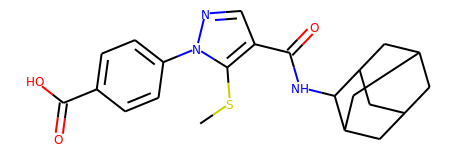

In [ ]:
smi = 'CSc1c(C(=O)NC2C3CC4CC(C3)CC2C4)cnn1-c1ccc(C(=O)O)cc1'
mol = Chem.MolFromSmiles(smi)
mol

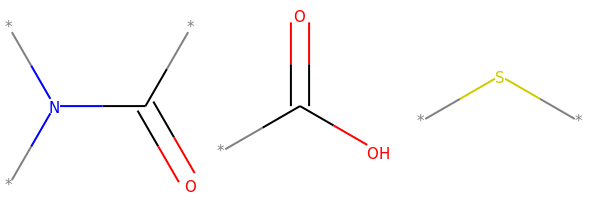

In [ ]:
funcgps = funcgps_generator(smi)
Draw.MolsToGridImage([Chem.MolFromSmiles(x) for x in funcgps])

In [ ]:
# export
def collect_funcgps(smi_list, n_jobs=1):
    """
    find the all functional groups from a list of smiles and return a dictionary of form {'FG smiles': count}
    """
    fragments = Counter()
    for mol_frag in mapper(n_jobs)(funcgps_generator, smi_list):
        fragments.update(mol_frag)
    return fragments

In [ ]:
smiles_list = ['O=C(O)c1ccc(C[S](=O)=O)cc1',
         'O=C(O)c1ccccc1',
          'N[C@H](CCC=O)C(=O)O',
          'N[C@@H](CCC=O)C(=O)O'
         ]

collect_funcgps(smiles_list)

Counter({'[*][C](=[O])[O][H]': 4,
         '[*][S](=[O])=[O]': 1,
         '[*][N]([H])[H]': 2,
         '[*][C]([H])=[O]': 2})

## Scaffold Similarity

In [ ]:
#export
import sys
from functools import partial
sys.path.append('..')
from molds.DSsplitter import generate_scaffold

def collect_scaffolds(smi_list, n_jobs=1):
    """
    find the all scaffolds from a list of smiles and return a dictionary of form {'scaffold': count}
    the liner molecules have no scaffold, will be represented as ''.
    """
    scaffolds = Counter()
    map_ = mapper(n_jobs)
    scaffolds = Counter(
        map_(partial(generate_scaffold), smi_list))
    if None in scaffolds:
        scaffolds.pop(None)
    return scaffolds

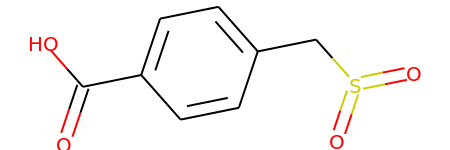

In [ ]:
smi = 'O=C(O)c1ccc(C[S](=O)=O)cc1'
mol = Chem.MolFromSmiles(smi)
mol

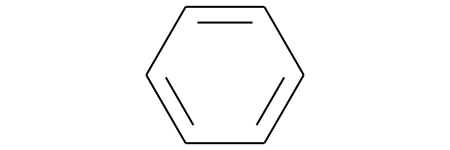

In [ ]:
scaffold = generate_scaffold(smi)
Chem.MolFromSmiles(scaffold)

In [ ]:
collect_scaffolds(smiles_list)

Counter({'c1ccccc1': 2, '': 2})

## Nearest Neighbor Similarity (SNN)
SNN is the average Tanimoto Similarity between a molecule from the test set ad its nearest neighbor molecule in the training set.

In [ ]:
#export
def SNN(train_smiles, test_smiles,
       n_jobs=1, device='cpu', fp_type='morgan', p=1):
    '''
    Computes average max similarities of test SMILES to train SMILES
    '''
    train_fps = collect_fingerprints(train_smiles, n_jobs=n_jobs)
    test_fps = collect_fingerprints(test_smiles, n_jobs=n_jobs)
    return average_agg_tanimoto(train_fps, test_fps,
                                    device=device, agg='max')

## Internal Diversity
Internal diversity arresses the chemical diversity within a set of molecules. A higher values corresponds to a higher diversity.

In [ ]:
#export
def internal_diversity(smi_list, n_jobs=1, device='cpu', p=1):
    """
    Computes internal diversity as:
    1/|A|^2 sum_{x, y in AxA} (1-tanimoto(x, y))
    """
    morgan_fps = collect_fingerprints(smi_list, n_jobs=n_jobs)
    return 1 - (average_agg_tanimoto(morgan_fps, morgan_fps,
                                     agg='mean', device=device, p=p)).mean()